# Capstone project Notebook

## Data Collection

In [1]:
import requests

### Getting the boroughs of Canada

In [2]:
response=requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')

In [3]:
print(response.status_code)

200


In [4]:
from bs4 import BeautifulSoup

Parsing the HTMlFile

In [5]:
soup = BeautifulSoup(response.content, 'html.parser')

In [6]:

table = soup.find(lambda tag: tag.name=='table') 


In [7]:
import pandas as pd

Turning the HTML into a dataframe

In [8]:
def tableDataText(table):    
    """Parses a html segment started with tag <table> followed 
    by multiple <tr> (table rows) and inner <td> (table data) tags. 
    It returns a list of rows with inner columns. 
    Accepts only one <th> (table header/data) in the first row.
    """
    def rowgetDataText(tr, coltag='td'): # td (data) or th (header)       
        return [td.get_text(strip=True) for td in tr.find_all(coltag)]  
    rows = []
    trs = table.find_all('tr')
    headerow = rowgetDataText(trs[0], 'th')
    if headerow: # if there is a header row include first
        rows.append(headerow)
        trs = trs[1:]
    for tr in trs: # for every table row
        rows.append(rowgetDataText(tr, 'td') ) # data row       
    return rows

In [9]:
list_table = tableDataText(table)
list_table[:2]

[['Postal Code', 'Borough', 'Neighbourhood'],
 ['M1A', 'Not assigned', 'Not assigned']]

In [10]:
import pandas as pd

dftable = pd.DataFrame(list_table[1:], columns=list_table[0])
dftable.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


Getting rid of the rows with unassigned boroughs

In [11]:
df2=dftable[dftable['Borough'] != 'Not assigned']

In [12]:
df2.head()

,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


Cleaning the dataframe

In [13]:
df3=df2.reset_index()

In [14]:
df3.drop(['index'],axis=1)

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C..."
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


In [15]:
df3.shape

(103, 4)

### Getting Geospatial coordinates for each neighborhood

In [16]:
df_postal_code=pd.read_csv(r"C:\Users\ngoup\Downloads\Geospatial_Coordinates.csv")

In [17]:
df_postal_code.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Joining the 2 dataframes

In [18]:
df4=df3.join(df_postal_code.set_index('Postal Code'), on='Postal Code')

In [19]:
df4.drop(['index'],axis=1,inplace=True)

In [20]:
df4.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [21]:
df4.shape

(103, 5)

### Getting the coordinates of Toronto

In [22]:
from geopy.geocoders import Nominatim
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geographical coordinate of Toronto are 43.6534817, -79.3839347.


### Visualizing Toronto's neighborhoods

In [23]:
import folium
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df4['Latitude'], df4['Longitude'], df4['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [24]:
CLIENT_ID = 'R40QKUUUNKJSYVR3XOEPZW04DKKS5PLER2H3Q3OW3OQT1R04' # your Foursquare ID
CLIENT_SECRET = 'JFAOQG1K4M22RGY0F42GV2CGTNX3JQERYL5NOXL1N1XDUYXL' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value


In [26]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Getting toronto venues

In [27]:
toronto_venues = getNearbyVenues(names=df4['Neighbourhood'],
                                   latitudes=df4['Latitude'],
                                   longitudes=df4['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

In [28]:
print(toronto_venues.shape)
toronto_venues.head()

(2122, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Brookbanks Pool,43.751389,-79.332184,Pool
2,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


### Getting New York venues

In [29]:
latitude_NY=40.7127281
longitude_NY=-74.0060152

In [30]:
NY_venues = getNearbyVenues(names=["NY_office"],
                                   latitudes=[latitude_NY],
                                   longitudes=[longitude_NY]
                                  )

NY_office


In [31]:
NY_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,NY_office,40.712728,-74.006015,The Bar Room at Temple Court,40.711448,-74.006802,Hotel Bar
1,NY_office,40.712728,-74.006015,"The Beekman, A Thompson Hotel",40.711173,-74.006702,Hotel
2,NY_office,40.712728,-74.006015,Alba Dry Cleaner & Tailor,40.711434,-74.006272,Laundry Service
3,NY_office,40.712728,-74.006015,City Hall Park,40.711893,-74.007792,Park
4,NY_office,40.712728,-74.006015,Gibney Dance Center Downtown,40.713923,-74.005661,Dance Studio
...,...,...,...,...,...,...,...
95,NY_office,40.712728,-74.006015,Skin Laundry TriBeCa,40.716404,-74.008570,Spa
96,NY_office,40.712728,-74.006015,Residence Inn by Marriott New York Downtown Ma...,40.709563,-74.009718,Hotel
97,NY_office,40.712728,-74.006015,Poke Bowl,40.709722,-74.006854,Poke Place
98,NY_office,40.712728,-74.006015,John Varvatos at the Oculus,40.711804,-74.011554,Clothing Store


## Data preprocessing

### Creating a dataframe including Toronto and New York venues

In [32]:
toronto_NY_venues=toronto_venues.append(NY_venues)

In [33]:
toronto_NY_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Brookbanks Pool,43.751389,-79.332184,Pool
2,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


In [34]:
toronto_NY_venues.tail()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
95,NY_office,40.712728,-74.006015,Skin Laundry TriBeCa,40.716404,-74.008570,Spa
96,NY_office,40.712728,-74.006015,Residence Inn by Marriott New York Downtown Ma...,40.709563,-74.009718,Hotel
97,NY_office,40.712728,-74.006015,Poke Bowl,40.709722,-74.006854,Poke Place
98,NY_office,40.712728,-74.006015,John Varvatos at the Oculus,40.711804,-74.011554,Clothing Store
99,NY_office,40.712728,-74.006015,Gunbae,40.714529,-74.010242,Korean Restaurant


One hot encoding the dataframe to prepare for clustering

In [35]:
toronto_NY_onehot = pd.get_dummies(toronto_NY_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_NY_onehot['Neighborhood'] = toronto_NY_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_NY_onehot.columns[-1]] + list(toronto_NY_onehot.columns[:-1])
toronto_NY_onehot = toronto_NY_onehot[fixed_columns]

toronto_NY_onehot.head()

,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Truck Stop,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
toronto_NY_onehot.columns.to_list()

['Yoga Studio',
 'Accessories Store',
 'Adult Boutique',
 'Afghan Restaurant',
 'Airport',
 'Airport Food Court',
 'Airport Gate',
 'Airport Lounge',
 'Airport Service',
 'Airport Terminal',
 'American Restaurant',
 'Antique Shop',
 'Aquarium',
 'Art Gallery',
 'Art Museum',
 'Arts & Crafts Store',
 'Asian Restaurant',
 'Athletics & Sports',
 'Auto Garage',
 'Auto Workshop',
 'BBQ Joint',
 'Baby Store',
 'Bagel Shop',
 'Bakery',
 'Bank',
 'Bar',
 'Baseball Field',
 'Baseball Stadium',
 'Basketball Stadium',
 'Beach',
 'Bed & Breakfast',
 'Beer Bar',
 'Beer Store',
 'Belgian Restaurant',
 'Bike Shop',
 'Bistro',
 'Boat or Ferry',
 'Bookstore',
 'Boutique',
 'Boxing Gym',
 'Brazilian Restaurant',
 'Breakfast Spot',
 'Brewery',
 'Bridal Shop',
 'Bubble Tea Shop',
 'Building',
 'Burger Joint',
 'Burrito Place',
 'Bus Line',
 'Bus Station',
 'Bus Stop',
 'Butcher',
 'Cafeteria',
 'Café',
 'Cajun / Creole Restaurant',
 'Candy Store',
 'Caribbean Restaurant',
 'Cheese Shop',
 'Chinese Restaur

Grouping cells by Neighborhood

In [38]:
toronto_NY_grouped = toronto_NY_onehot.groupby('Neighborhood').mean().reset_index()
toronto_NY_grouped

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,...,Truck Stop,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,"Willowdale, Willowdale West",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93,Woburn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
94,Woodbine Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95,York Mills West,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
toronto_NY_grouped.shape

(97, 272)

In [40]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

creating a dataframe to display the top 10 venues for each neighborhood.

In [41]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_NY_grouped['Neighborhood']

for ind in np.arange(toronto_NY_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_NY_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Latin American Restaurant,Skating Rink,Breakfast Spot,Women's Store,Doner Restaurant,Diner,Discount Store,Distribution Center,Dog Run
1,"Alderwood, Long Branch",Pizza Place,Gym,Coffee Shop,Skating Rink,Pharmacy,Pub,Sandwich Place,Women's Store,Dim Sum Restaurant,Deli / Bodega
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Park,Fried Chicken Joint,Diner,Sandwich Place,Bridal Shop,Deli / Bodega,Restaurant,Supermarket
3,Bayview Village,Café,Japanese Restaurant,Bank,Chinese Restaurant,Women's Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run
4,"Bedford Park, Lawrence Manor East",Italian Restaurant,Coffee Shop,Sandwich Place,Café,Pharmacy,Butcher,Pub,Sushi Restaurant,Restaurant,Thai Restaurant


In [45]:
NY_dataset=toronto_NY_grouped[toronto_NY_grouped["Neighborhood"]=='NY_office']

In [46]:
NY_dataset

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,...,Truck Stop,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
53,NY_office,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.01,0.0,0.0,0.0,0.01,0.02,0.0,0.01


In [48]:
toronto_NY_grouped.drop(toronto_NY_grouped[toronto_NY_grouped["Neighborhood"]=='NY_office'].index, axis=0, inplace=True)

In [49]:
toronto_NY_grouped.shape

(96, 272)

In [50]:
toronto_grouped_clustering = toronto_NY_grouped.drop('Neighborhood', 1)

In [51]:
NY_dataset = NY_dataset.drop('Neighborhood', 1)

##  Data Clustering

Trying to find the best k value for clustering

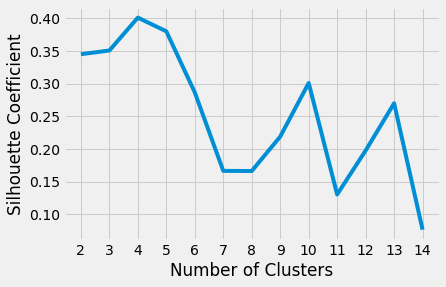

In [54]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
# The list holds the silhouette coefficients for each k
silhouette_coefficients = []

for k in range(2, 15):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(toronto_grouped_clustering)
    score = silhouette_score(toronto_grouped_clustering, kmeans.labels_)
    silhouette_coefficients.append(score)
plt.style.use("fivethirtyeight")
plt.plot(range(2, 15), silhouette_coefficients)
plt.xticks(range(2, 15))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

Clustering the neighborhood in 4 clusters

In [55]:

kclusters = 4



# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [58]:
# add clustering labels
neighborhoods_venues_sorted.drop(neighborhoods_venues_sorted[neighborhoods_venues_sorted["Neighborhood"]=='NY_office'].index, axis=0, inplace=True)
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df4

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

toronto_merged.head() # check the last columns!

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,0.0,Park,Food & Drink Shop,Pool,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run
1,M4A,North York,Victoria Village,43.725882,-79.315572,0.0,Portuguese Restaurant,Coffee Shop,Pizza Place,French Restaurant,Hockey Arena,Distribution Center,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0.0,Coffee Shop,Pub,Bakery,Park,Café,Theater,Breakfast Spot,French Restaurant,Health Food Store,Historic Site
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0.0,Clothing Store,Accessories Store,Furniture / Home Store,Event Space,Miscellaneous Shop,Vietnamese Restaurant,Coffee Shop,Boutique,Dog Run,Dim Sum Restaurant
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0.0,Coffee Shop,Sushi Restaurant,Yoga Studio,Bar,Beer Bar,Smoothie Shop,Sandwich Place,Burrito Place,Café,Portuguese Restaurant


Getting rid of rows with null values

In [59]:
toronto_merged_final=toronto_merged.dropna()

In [60]:
toronto_merged_final.isnull().sum()

Postal Code               0
Borough                   0
Neighbourhood             0
Latitude                  0
Longitude                 0
Cluster Labels            0
1st Most Common Venue     0
2nd Most Common Venue     0
3rd Most Common Venue     0
4th Most Common Venue     0
5th Most Common Venue     0
6th Most Common Venue     0
7th Most Common Venue     0
8th Most Common Venue     0
9th Most Common Venue     0
10th Most Common Venue    0
dtype: int64

In [61]:
toronto_merged = toronto_merged_final.astype({"Cluster Labels": int})
#toronto_merged["Cluster Labels"].fillna(5,inplace=True)

Visualizing the clusters

In [62]:
import matplotlib.cm as cm
import matplotlib.colors as colors
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'],toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Assigning a cluster to NY office

In [63]:
kmeans.predict(NY_dataset)

array([0])

It seems like the NY office neighborhood belong to the first cluster

In [68]:
cluster0=toronto_merged[toronto_merged["Cluster Labels"]==0]

In [69]:
cluster0.shape

(89, 16)

### Visualization of the neighborhood similar to the NY office neighborhood

In [71]:
map_cluster0 = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters


# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cluster0['Latitude'], cluster0['Longitude'],cluster0['Neighbourhood'], cluster0['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_cluster0)
       
map_cluster0